# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

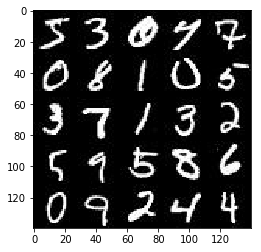

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

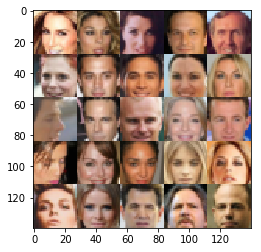

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/mithun/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    keep_probability = 0.8
    
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.dropout(x1, keep_probability)
        
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_probability)
        
        x3 = tf.layers.conv2d(x2, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_probability)
        
        ##x4 = tf.layers.conv2d(x3, 256, 5, strides=2, padding="same")
        ##x4 = tf.layers.batch_normalization(x4, training=True)
        ##x4 = tf.maximum(alpha*x4, x4)
        
        x4 = tf.reshape(x3, (-1, 2*2*128))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    keep_probability = 0.8
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, units=4*4*512)
        h1 = tf.reshape(h1, (-1, 4, 4, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum( 0.1 * h1, h1)
        #h1 = tf.nn.dropout(h1, keep_probability)
        
        h2 = tf.layers.conv2d_transpose(h1, filters=128, kernel_size=4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(0.1 * h2, h2)
        #h2 = tf.nn.dropout(h2, keep_probability)
        
        h3 = tf.layers.conv2d_transpose(h2, filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.nn.dropout(h3, keep_probability)
        h3 = tf.maximum(0.1 * h3, h3)
        #h3 = tf.nn.dropout(h3, keep_probability)
        
        h3 = tf.layers.conv2d_transpose(h3, filters=32, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(0.1 * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, filters=out_channel_dim, kernel_size=3, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    step = 0
    
    samples, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4407... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 1.5037... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.8997
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 1.5599... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.9292
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.2881


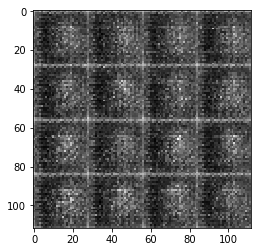

Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 1.0773
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 1.2674
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 1.2400... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.9964
Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 1.3617


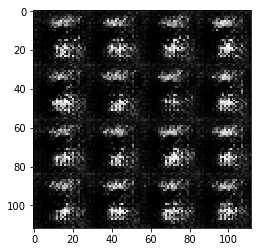

Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 1.0648
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.2650
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.5268... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.2147... Generator Loss: 1.1467
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 1.0320


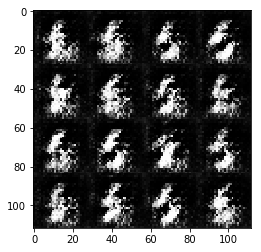

Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 1.2546
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 1.1765
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.1100
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 1.2833
Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 1.2229


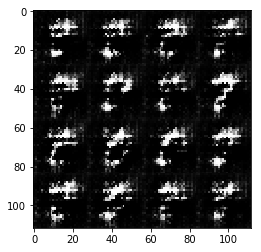

Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 0.9894
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 1.3122
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 1.1948
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 1.0350
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 1.1629


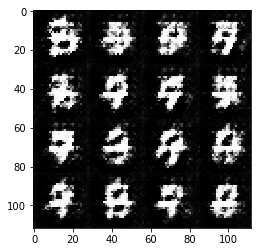

Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.1453
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.9628
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.2176
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 1.0160


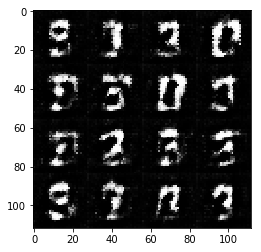

Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 1.0049
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 1.3689
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 1.0478
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.1549
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 1.0948
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 1.1197


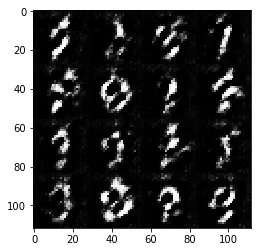

Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 1.2767... Generator Loss: 1.0252
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 1.0562
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 1.1073
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 1.0251


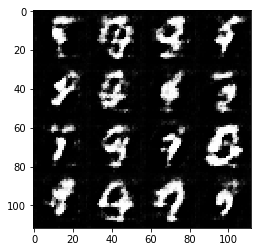

Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 1.0746
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 0.9619
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 1.0477


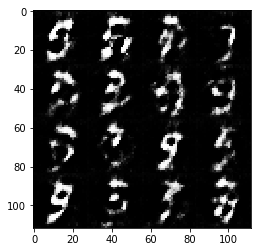

Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 1.2127
Epoch 1/2... Discriminator Loss: 0.9921... Generator Loss: 1.3748
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 1.0372
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 1.0549
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.1575
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.9443
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 1.1159
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 0.8649


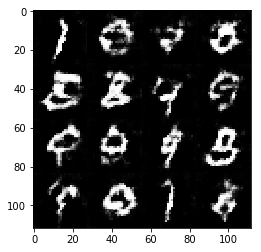

Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.9582
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 1.0146
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 1.3218... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 1.2245
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 1.0495
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 1.2928
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.9686


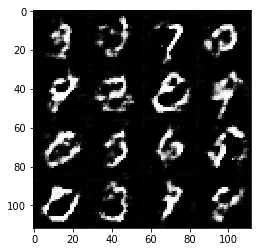

Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 1.0083
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.9701
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.9153
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 1.0010
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 1.0637


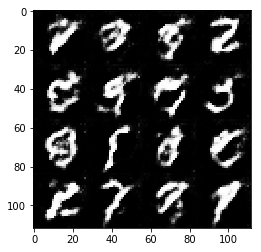

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 1.0792
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 1.1560
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 1.0496
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.2363... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 1.0164
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.9418


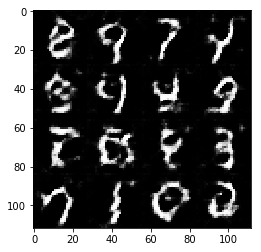

Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.8899
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.9608
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 1.1228


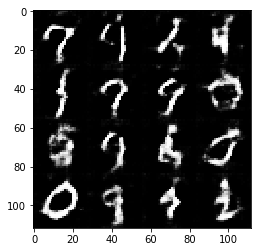

Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.9574


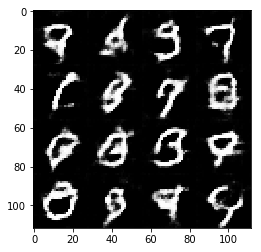

Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.7842
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.8779


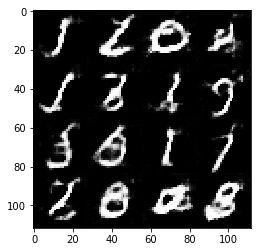

Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.9869
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 1.1198
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.9802
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.9907
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 0.9467


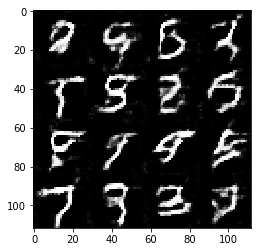

Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.8604
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.5672... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.3393... Generator Loss: 0.9569
Epoch 1/2... Discriminator Loss: 1.2557... Generator Loss: 0.8050
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 0.8505


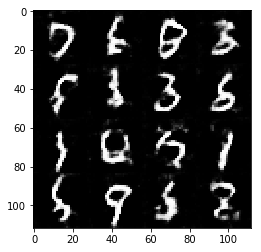

Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.9509
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 1.0176


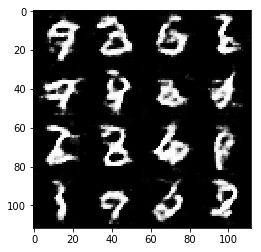

Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.8762
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.8571


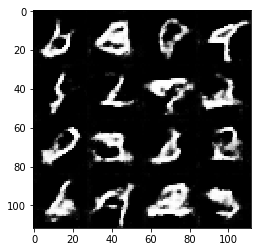

Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 1.0316
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.8933
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.9162
Epoch 2/2... Discriminator Loss: 1.4644... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.9481


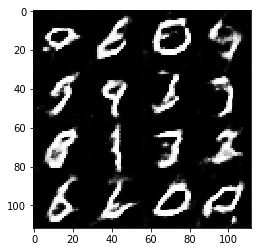

Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.9576
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.9136


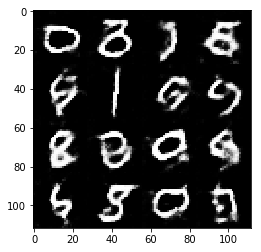

Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.8780
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.8570
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.8995


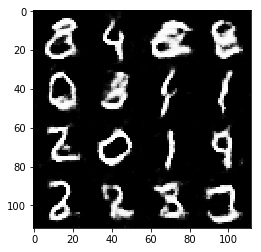

Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.8461
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.8847


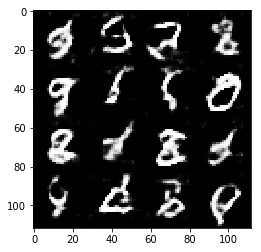

Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.8411
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.9013
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.9607


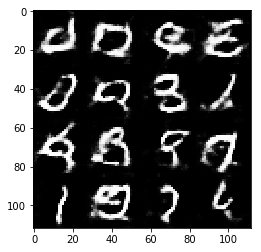

Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.8900
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 0.9498
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.8761
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.9209
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.9088


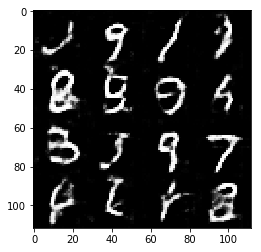

Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.2634... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 1.4111... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.8091
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.8946


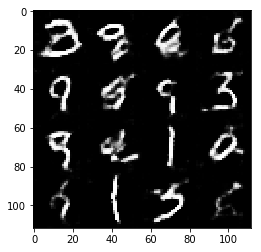

Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.9308
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 1.2321... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.8425


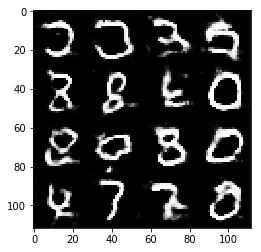

Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.9147
Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.8869


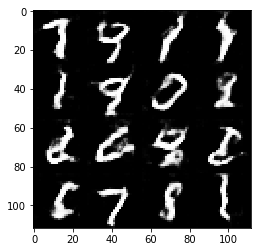

Epoch 2/2... Discriminator Loss: 1.3090... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.9336
Epoch 2/2... Discriminator Loss: 1.3196... Generator Loss: 0.9706
Epoch 2/2... Discriminator Loss: 1.3461... Generator Loss: 0.8745
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.8942


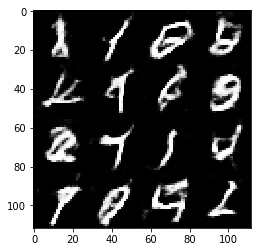

Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.9539
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.8678
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.8523
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.8805
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.9007


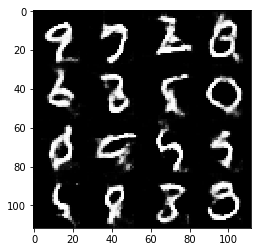

Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 1.3966... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.8934


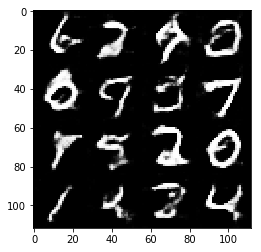

Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.8757
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.8936
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.8787


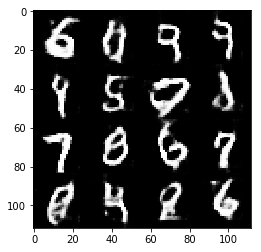

Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8868
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 0.9353


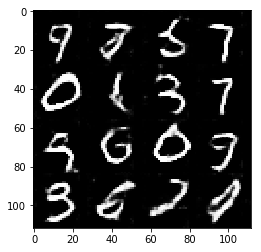

Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.8111
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.9519
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.8741
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 1.4094... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 0.8162


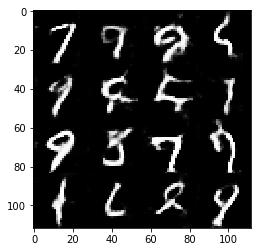

Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.9505
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.9591
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.9663
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.7877


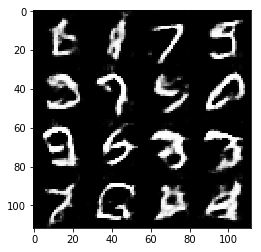

Epoch 2/2... Discriminator Loss: 1.2875... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.8859
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 0.9182
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.9426
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.8887


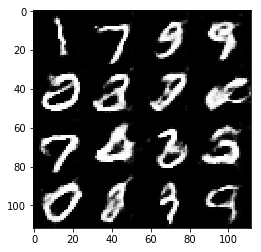

Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.9406


In [56]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 1.2783
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.5155
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.3109


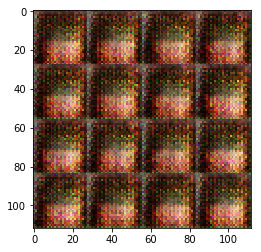

Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.6017
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.4765
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 2.1548
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.8775


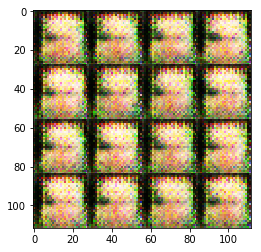

Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.6827
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 2.2200
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.6270
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.8030
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 2.1711


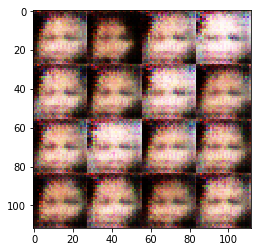

Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.5824
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.4148


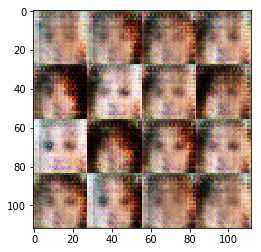

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.9659


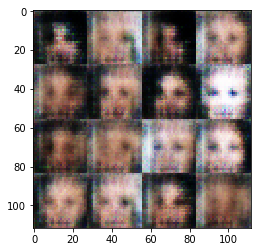

Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.2411


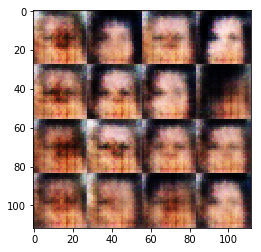

Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.4008
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.2786


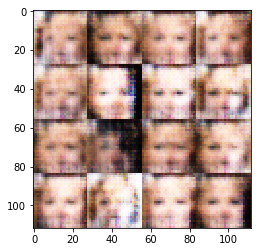

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8741


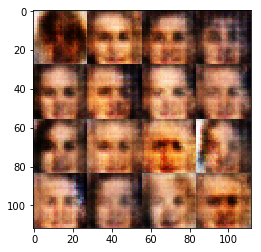

Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8803


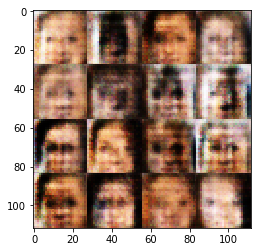

Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.9664


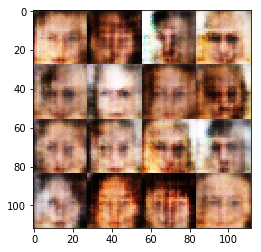

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.8061


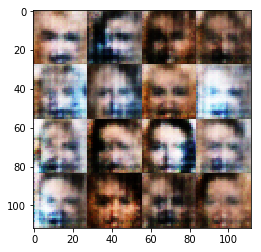

Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8161


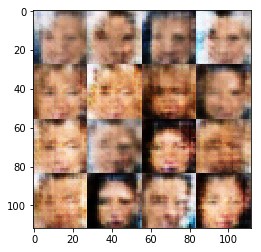

Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.9074


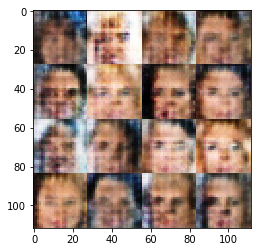

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9350


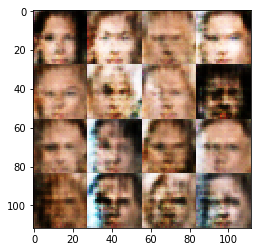

Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.1442


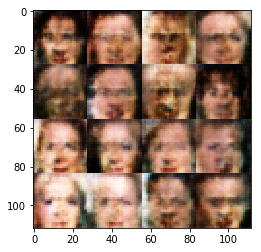

Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7779


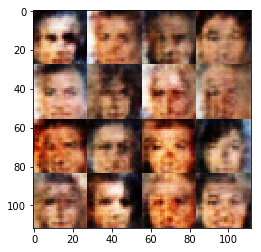

Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9550


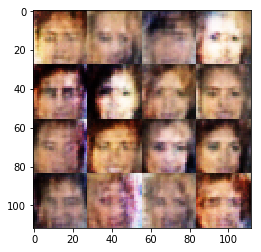

Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8337


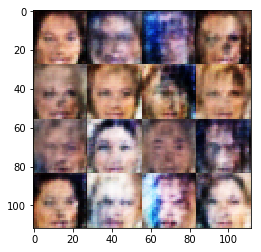

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.9213


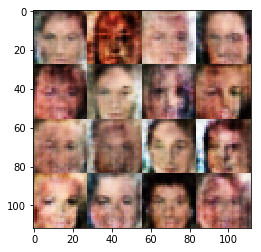

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8148


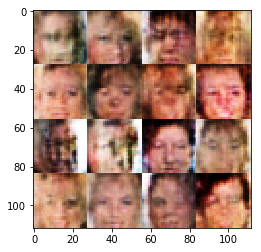

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.8712


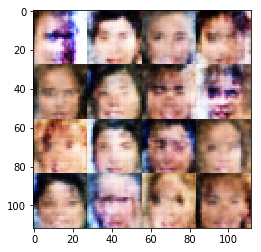

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8170


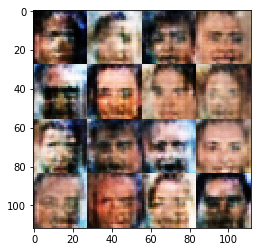

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8092


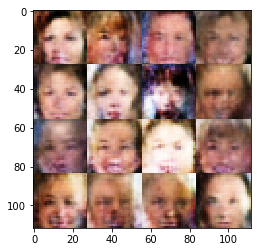

Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.9588


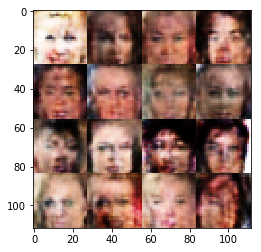

Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8003


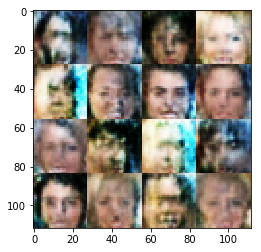

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9221


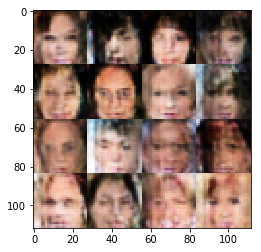

Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7864


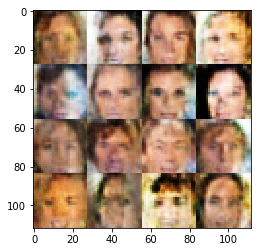

Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8754


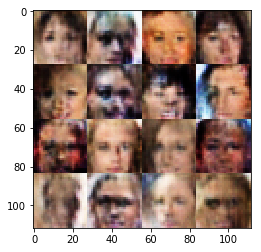

Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.9651


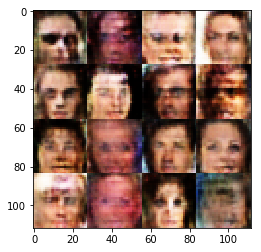

Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6898


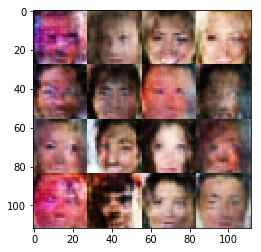

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8471


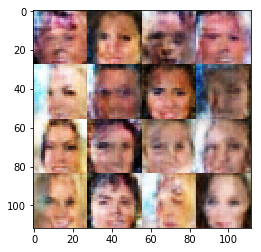

Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7980


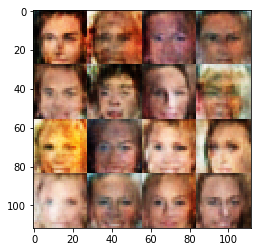

Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8638


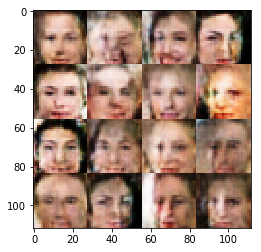

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8209


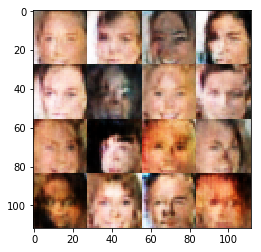

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7896


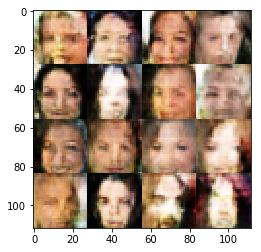

Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8929


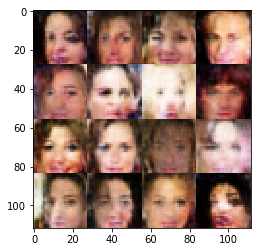

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8513


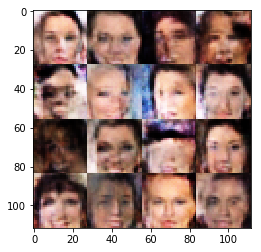

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8318


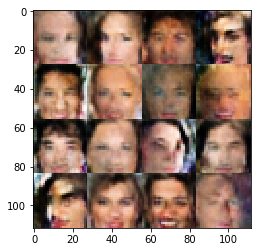

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.9077


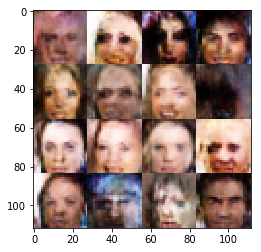

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7644


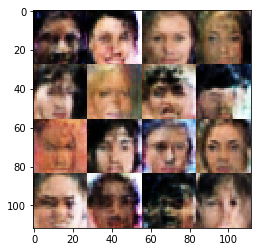

Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8647


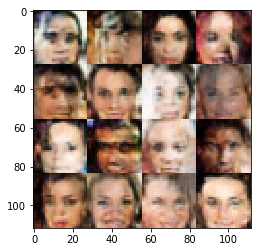

Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8720


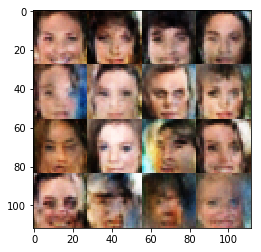

Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8636


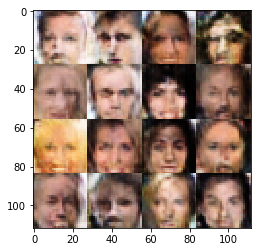

Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7137


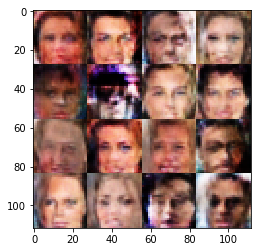

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8538


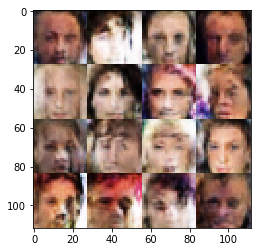

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8461


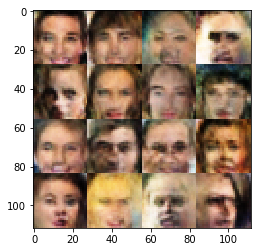

Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.9583


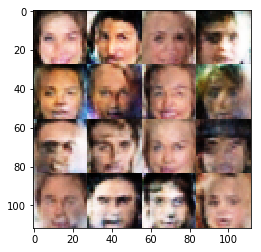

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8693


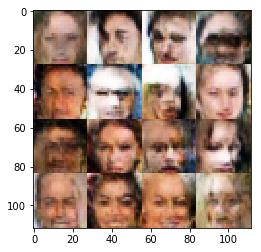

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8689


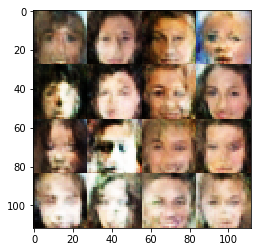

Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8496


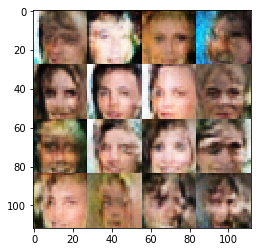

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8361


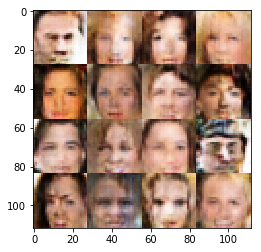

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8662


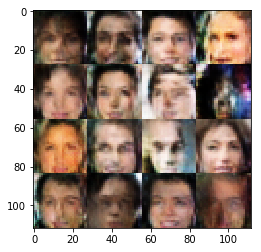

Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8221


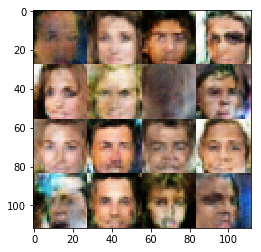

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.9231


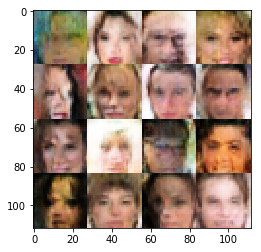

Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7616


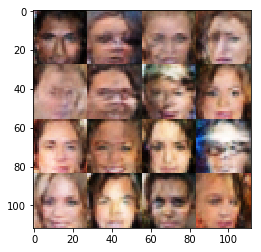

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.8816


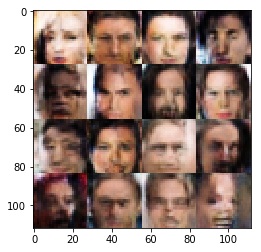

Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.9366


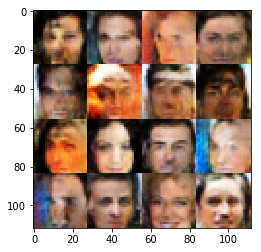

Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8490


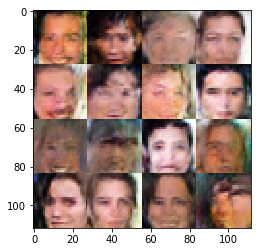

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8380


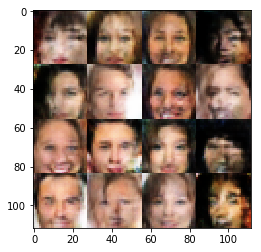

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7761


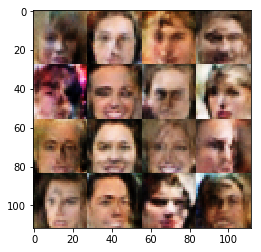

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8152


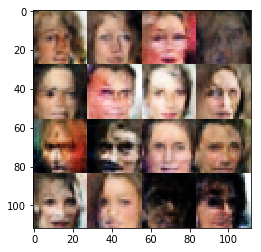

Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.8106


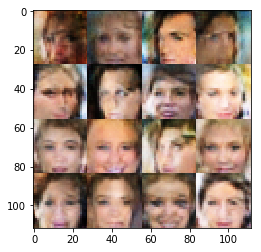

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8092


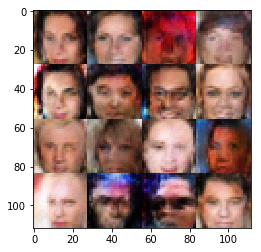

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7835


In [57]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.